## Check GPU presence

In [1]:
import sys
print(sys.executable)
print(sys.version)

#import sys
#!{sys.executable} -m pip uninstall torch torchvision torchaudio -y
#!{sys.executable} -m pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu121

import torch
import torchvision

print(f"PyTorch: {torch.__version__}")
print(f"Torchvision: {torchvision.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")

C:\Users\aaron\AppData\Local\Programs\Python\Python311\python.exe
3.11.9 (tags/v3.11.9:de54cf5, Apr  2 2024, 10:12:12) [MSC v.1938 64 bit (AMD64)]
PyTorch: 2.5.1+cu121
Torchvision: 0.20.1+cu121
CUDA available: True


In [2]:
from torch.utils.data import Dataset

# Custom Dataset class
class ChipDataset(Dataset):
    def __init__(self, image_paths, labels, transform=None):
        self.image_paths = image_paths
        self.labels = labels
        self.transform = transform
        
    def __len__(self):
        return len(self.image_paths)
    
    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        image = Image.open(img_path).convert('RGB')
        
        if self.transform:
            image = self.transform(image)
        
        label = torch.tensor(self.labels[idx], dtype=torch.long)  # Add dtype=torch.long
        return image, label

## Collect / analyze image database

Collect all images in the database, count the number of samples in each brand, and present in a plot. For this model, each model must have a minimum of 20 images to be used.


[notice] A new release of pip is available: 25.1.1 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip
ERROR: To modify pip, please run the following command:
C:\Users\aaron\AppData\Local\Programs\Python\Python311\python.exe -m pip install --upgrade pip --quiet


Found 1775 total images across 134 brands

Total images for training: 1576


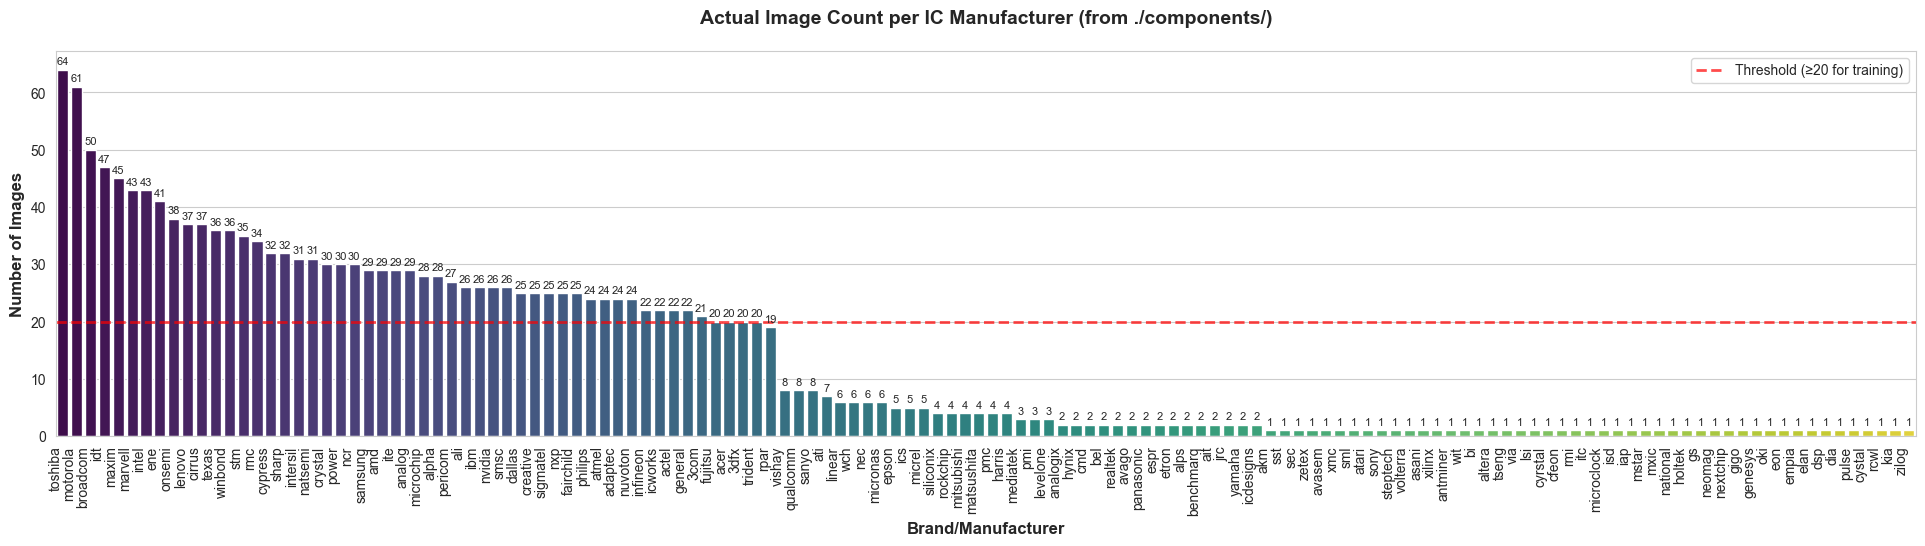

In [3]:
!pip install --upgrade pip --quiet

# Section 1: Data Augmentation & Dataset Setup
import os
from PIL import Image
import pandas as pd
from collections import Counter
import matplotlib.pyplot as plt
import seaborn as sns

# Define your data directory
DATA_DIR = './components/'

# Scan the directory and build the dataset directly from files
brand_counts = Counter()
all_files = []

for filename in os.listdir(DATA_DIR):
    if filename.endswith('.png'):
        brand = filename.split('_')[0]
        brand_counts[brand] += 1
        all_files.append(filename)

# Create dataframe from actual files
df = pd.DataFrame([
    {'Brand': brand, 'Moniker': brand, 'Count': count}
    for brand, count in brand_counts.items()
]).sort_values('Count', ascending=False)

print(f"Found {len(all_files)} total images across {len(df)} brands")

# Create visualization
plt.figure(figsize=(24, 5))
sns.set_style("whitegrid")

# Create bar plot
ax = sns.barplot(data=df, x='Brand', y='Count', hue='Brand', palette='viridis', legend=False)

# Customize the plot
plt.xticks(rotation=90, ha='right')
plt.xlabel('Brand/Manufacturer', fontsize=12, fontweight='bold')
plt.ylabel('Number of Images', fontsize=12, fontweight='bold')
plt.title('Actual Image Count per IC Manufacturer (from ./components/)', fontsize=14, fontweight='bold', pad=20)

# Add value labels on top of bars
for i, v in enumerate(df['Count']):
    ax.text(i, v + 0.5, str(v), ha='center', va='bottom', fontsize=8)

# Add threshold line
plt.axhline(y=20, color='red', linestyle='--', linewidth=2, alpha=0.7, label='Threshold (≥20 for training)')
plt.legend()


# Filter to brands with >= 20 images
min_df = df[df['Count'] >= 20].copy()

# Get list of valid brands (these will be your classes)
valid_brands = min_df['Moniker'].tolist()
brand_to_idx = {brand: idx for idx, brand in enumerate(sorted(valid_brands))}
idx_to_brand = {idx: brand for brand, idx in brand_to_idx.items()}

# Collect all valid images (only from brands with >= 20 images)
image_paths = []
labels = []

for filename in all_files:
    brand = filename.split('_')[0]
    
    if brand in brand_to_idx:
        image_paths.append(os.path.join(DATA_DIR, filename))
        labels.append(brand_to_idx[brand])

print(f"\nTotal images for training: {len(image_paths)}")

## Reduce dataset to minimum viable brands

To be used in the model, each brand must contain a minimum of 20 samples. Brands with less than 20 samples are discarded from the dataset.

In [4]:
# Section 3: Download/Build the Model
import torch.nn as nn
from torchvision import models

# Check if GPU is available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")
if device.type == 'cuda':
    print(f"GPU: {torch.cuda.get_device_name(0)}")
    print(f"Memory: {torch.cuda.get_device_properties(0).total_memory / 1024**3:.2f} GB")

# Load pretrained ResNet-18
print(f"\n{'='*60}")
print("Loading ResNet-18 with ImageNet pretrained weights...")

model = models.resnet18(pretrained=True)

# Freeze early layers (optional - keeps ImageNet features)
for param in model.parameters():
    param.requires_grad = False

# Replace the final fully connected layer
num_classes = len(brand_to_idx)
model.fc = nn.Linear(model.fc.in_features, num_classes)

# Move model to GPU/CPU
model = model.to(device)

print(f"Model architecture modified:")
print(f"  Original output: 1000 classes (ImageNet)")
print(f"  New output: {num_classes} classes (IC brands)")
print(f"  Frozen layers: Early conv layers (transfer learning)")
print(f"  Trainable layers: Final FC layer")

# Count parameters
total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f"\nModel parameters:")
print(f"  Total parameters: {total_params:,}")
print(f"  Trainable parameters: {trainable_params:,}")
print(f"  Frozen parameters: {total_params - trainable_params:,}")

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.fc.parameters(), lr=0.001)

# Learning rate scheduler
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, 
    mode='min',
    factor=0.5,
    patience=3,
    verbose=True
)

print(f"\nTraining configuration:")
print(f"  Loss function: CrossEntropyLoss")
print(f"  Optimizer: Adam (lr=0.001)")
print(f"  Scheduler: ReduceLROnPlateau (factor=0.5, patience=3)")
print(f"\nModel ready for training!")

Using device: cuda
GPU: NVIDIA GeForce RTX 3060 Laptop GPU
Memory: 6.00 GB

Loading ResNet-18 with ImageNet pretrained weights...


C:\Users\aaron\AppData\Local\Programs\Python\Python311\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\aaron\AppData\Local\Programs\Python\Python311\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Model architecture modified:
  Original output: 1000 classes (ImageNet)
  New output: 51 classes (IC brands)
  Frozen layers: Early conv layers (transfer learning)
  Trainable layers: Final FC layer

Model parameters:
  Total parameters: 11,202,675
  Trainable parameters: 26,163
  Frozen parameters: 11,176,512

Training configuration:
  Loss function: CrossEntropyLoss
  Optimizer: Adam (lr=0.001)
  Scheduler: ReduceLROnPlateau (factor=0.5, patience=3)

Model ready for training!


C:\Users\aaron\AppData\Local\Programs\Python\Python311\Lib\site-packages\torch\optim\lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


## Split dataset into train / test / validation (80 / (80/20))

In [5]:
# Section 2: Train/Test/Validation Split
from sklearn.model_selection import train_test_split
import numpy as np
from torchvision import transforms

# Convert to numpy arrays for easier manipulation
image_paths = np.array(image_paths)
labels = np.array(labels)

print(f"Total dataset: {len(image_paths)} images")
print(f"Number of classes: {len(brand_to_idx)}")

# First split: 80% train+val, 20% test
# Stratify to ensure each brand is represented proportionally in each split
train_val_paths, test_paths, train_val_labels, test_labels = train_test_split(
    image_paths, 
    labels, 
    test_size=0.2,  # 20% for test
    stratify=labels,  # Maintain class distribution
    random_state=42
)

# Second split: Split train+val into 80% train, 20% val
# From the remaining 80%, take 20% for validation (which is 16% of total)
train_paths, val_paths, train_labels, val_labels = train_test_split(
    train_val_paths,
    train_val_labels,
    test_size=0.2,  # 20% of train_val = 16% of total
    stratify=train_val_labels,
    random_state=42
)

# Final split: ~64% train, ~16% val, ~20% test
print(f"\n{'='*60}")
print(f"Split Summary:")
print(f"  Training:   {len(train_paths)} images ({len(train_paths)/len(image_paths)*100:.1f}%)")
print(f"  Validation: {len(val_paths)} images ({len(val_paths)/len(image_paths)*100:.1f}%)")
print(f"  Test:       {len(test_paths)} images ({len(test_paths)/len(image_paths)*100:.1f}%)")

# Verify stratification - check distribution across splits
print(f"\n{'='*60}")
print(f"Verifying stratification (samples per brand):")
print(f"{'Brand':<15} {'Train':<8} {'Val':<8} {'Test':<8} {'Total':<8}")
print(f"{'-'*60}")

for brand in sorted(valid_brands):
    brand_idx = brand_to_idx[brand]
    train_count = np.sum(train_labels == brand_idx)
    val_count = np.sum(val_labels == brand_idx)
    test_count = np.sum(test_labels == brand_idx)
    total = train_count + val_count + test_count
    print(f"{brand:<15} {train_count:<8} {val_count:<8} {test_count:<8} {total:<8}")

# Training augmentations
train_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(degrees=15),
    transforms.ColorJitter(brightness=0.3, contrast=0.3, saturation=0.3, hue=0.1),
    transforms.RandomAffine(degrees=0, translate=(0.1, 0.1), scale=(0.9, 1.1)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Validation/Test augmentations
val_test_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Create datasets with appropriate transforms
train_dataset = ChipDataset(train_paths, train_labels, transform=train_transforms)
val_dataset = ChipDataset(val_paths, val_labels, transform=val_test_transforms)
test_dataset = ChipDataset(test_paths, test_labels, transform=val_test_transforms)

print(f"\n{'='*60}")
print(f"Datasets created:")
print(f"  Training dataset:   {len(train_dataset)} samples (with augmentation)")
print(f"  Validation dataset: {len(val_dataset)} samples (no augmentation)")
print(f"  Test dataset:       {len(test_dataset)} samples (no augmentation)")

# Create data loaders
BATCH_SIZE = 32

train_loader = torch.utils.data.DataLoader(
    train_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=0,  # Changed from 4 to 0 (Windows fix)
    pin_memory=True
)

val_loader = torch.utils.data.DataLoader(
    val_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=0,  # Changed from 4 to 0
    pin_memory=True
)

test_loader = torch.utils.data.DataLoader(
    test_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=0,  # Changed from 4 to 0
    pin_memory=True
)

print(f"\nDataLoaders created:")
print(f"  Batch size: {BATCH_SIZE}")
print(f"  Training batches:   {len(train_loader)}")
print(f"  Validation batches: {len(val_loader)}")
print(f"  Test batches:       {len(test_loader)}")

Total dataset: 1576 images
Number of classes: 51

Split Summary:
  Training:   1008 images (64.0%)
  Validation: 252 images (16.0%)
  Test:       316 images (20.1%)

Verifying stratification (samples per brand):
Brand           Train    Val      Test     Total   
------------------------------------------------------------
3com            14       3        4        21      
3dfx            13       3        4        20      
acer            13       3        4        20      
actel           14       4        4        22      
adaptec         15       4        5        24      
ali             17       4        5        26      
alpha           18       4        6        28      
amd             19       4        6        29      
analog          18       5        6        29      
atmel           15       4        5        24      
broadcom        32       8        10       50      
cirrus          23       6        8        37      
creative        16       4        5        25      

## Implement different transfer learning models

In [ ]:
# Section: Multi-Model Comparison

# Section: Multi-Model Comparison
import torch.nn as nn
from torchvision import models
import pandas as pd
import time
from sklearn.metrics import f1_score  # ADD THIS LINE

# Define models to test
models_to_test = {
    'ResNet-18': lambda: models.resnet18(pretrained=True),
    'ResNet-34': lambda: models.resnet34(pretrained=True),
    'ResNet-50': lambda: models.resnet50(pretrained=True),
    'EfficientNet-B0': lambda: models.efficientnet_b0(pretrained=True),
    'EfficientNet-B2': lambda: models.efficientnet_b2(pretrained=True),
    'EfficientNet-B4': lambda: models.efficientnet_b4(pretrained=True),
    'EfficientNet-B6': lambda: models.efficientnet_b6(pretrained=True),
    'EfficientNet-B7': lambda: models.efficientnet_b7(pretrained=True),    
    'MobileNet-V3': lambda: models.mobilenet_v3_large(pretrained=True),
    'DenseNet-121': lambda: models.densenet121(pretrained=True),
}

results = []

for model_name, model_fn in models_to_test.items():
    print(f"\n{'='*60}")
    print(f"Training {model_name}")
    print(f"{'='*60}\n")
    
    # Load model
    model = model_fn()
    
    # Modify final layer based on architecture
    num_classes = len(brand_to_idx)
    
    if 'resnet' in model_name.lower():
        # Freeze early layers
        for name, param in model.named_parameters():
            if 'layer1' in name or 'layer2' in name or 'conv1' in name or 'bn1' in name:
                param.requires_grad = False
        model.fc = nn.Linear(model.fc.in_features, num_classes)
        
    elif 'efficientnet' in model_name.lower():
        # Freeze early layers
        for i, child in enumerate(model.features.children()):
            if i < 5:  # Freeze first 5 blocks
                for param in child.parameters():
                    param.requires_grad = False
        model.classifier[1] = nn.Linear(model.classifier[1].in_features, num_classes)
        
    elif 'mobilenet' in model_name.lower():
        # Freeze early layers
        for i, child in enumerate(model.features.children()):
            if i < 10:  # Freeze first 10 blocks
                for param in child.parameters():
                    param.requires_grad = False
        model.classifier[3] = nn.Linear(model.classifier[3].in_features, num_classes)
        
    elif 'densenet' in model_name.lower():
        # Freeze early layers
        for name, param in model.named_parameters():
            if 'denseblock1' in name or 'denseblock2' in name:
                param.requires_grad = False
        model.classifier = nn.Linear(model.classifier.in_features, num_classes)
    
    model = model.to(device)
    
    # Training setup
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(
        filter(lambda p: p.requires_grad, model.parameters()),
        lr=0.0001
    )
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
        optimizer, mode='min', factor=0.5, patience=5, verbose=False
    )
    
    # Train for fewer epochs (for comparison)
    NUM_EPOCHS = 30
    best_val_acc = 0.0
    
    train_start = time.time()
    
    for epoch in range(NUM_EPOCHS):
        # Training
        model.train()
        train_loss = 0.0
        train_correct = 0
        train_total = 0
        
        for images, labels_batch in train_loader:
            images = images.to(device)
            labels_batch = labels_batch.to(device)
            
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels_batch)
            loss.backward()
            optimizer.step()
            
            train_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            train_total += labels_batch.size(0)
            train_correct += (predicted == labels_batch).sum().item()
        
        train_acc = 100 * train_correct / train_total
        
        # Validation
        model.eval()
        val_loss = 0.0
        val_correct = 0
        val_total = 0
        
        with torch.no_grad():
            for images, labels_batch in val_loader:
                images = images.to(device)
                labels_batch = labels_batch.to(device)
                
                outputs = model(images)
                loss = criterion(outputs, labels_batch)
                
                val_loss += loss.item()
                _, predicted = torch.max(outputs.data, 1)
                val_total += labels_batch.size(0)
                val_correct += (predicted == labels_batch).sum().item()
        
        val_acc = 100 * val_correct / val_total
        scheduler.step(val_loss / len(val_loader))
        
        if val_acc > best_val_acc:
            best_val_acc = val_acc
        
        # Print progress every 5 epochs
        if (epoch + 1) % 5 == 0:
            print(f"Epoch {epoch+1}/{NUM_EPOCHS}: Train Acc={train_acc:.2f}%, Val Acc={val_acc:.2f}%")
    
    train_time = time.time() - train_start
    
    # Test evaluation
    model.eval()
    test_correct = 0
    test_total = 0
    all_preds = []
    all_labels = []
    
    with torch.no_grad():
        for images, labels_batch in test_loader:
            images = images.to(device)
            labels_batch = labels_batch.to(device)
            
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            test_total += labels_batch.size(0)
            test_correct += (predicted == labels_batch).sum().item()
            
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels_batch.cpu().numpy())
    
    test_acc = 100 * test_correct / test_total
    test_f1 = f1_score(all_labels, all_preds, average='weighted')
    
    # Count parameters
    total_params = sum(p.numel() for p in model.parameters())
    trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    
    results.append({
        'Model': model_name,
        'Test Accuracy': f'{test_acc:.2f}%',
        'Test F1': f'{test_f1:.4f}',
        'Best Val Acc': f'{best_val_acc:.2f}%',
        'Total Params': f'{total_params/1e6:.2f}M',
        'Trainable Params': f'{trainable_params/1e6:.2f}M',
        'Training Time': f'{train_time:.1f}s'
    })
    
    print(f"\n{model_name} Results:")
    print(f"  Test Accuracy: {test_acc:.2f}%")
    print(f"  Test F1: {test_f1:.4f}")
    print(f"  Training Time: {train_time:.1f}s\n")

# Display results table
print(f"\n{'='*80}")
print("MODEL COMPARISON SUMMARY")
print(f"{'='*80}\n")

df_results = pd.DataFrame(results)
print(df_results.to_string(index=False))

# Find best model
best_idx = df_results['Test F1'].str.replace('%', '').astype(float).idxmax()
print(f"\n🏆 Best Model: {df_results.loc[best_idx, 'Model']} "
      f"(Test Acc: {df_results.loc[best_idx, 'Test Accuracy']}, "
      f"F1: {df_results.loc[best_idx, 'Test F1']})")


Training ResNet-18



C:\Users\aaron\AppData\Local\Programs\Python\Python311\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\aaron\AppData\Local\Programs\Python\Python311\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
C:\Users\aaron\AppData\Local\Programs\Python\Python311\Lib\site-packages\torch\optim\lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 5/30: Train Acc=60.81%, Val Acc=44.44%
Epoch 10/30: Train Acc=85.02%, Val Acc=60.71%
Epoch 15/30: Train Acc=96.23%, Val Acc=62.70%
Epoch 20/30: Train Acc=99.50%, Val Acc=66.67%
Epoch 25/30: Train Acc=99.90%, Val Acc=67.86%
Epoch 30/30: Train Acc=99.80%, Val Acc=69.05%

ResNet-18 Results:
  Test Accuracy: 69.30%
  Test F1: 0.6887
  Training Time: 543.3s


Training ResNet-34



C:\Users\aaron\AppData\Local\Programs\Python\Python311\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\aaron\AppData\Local\Programs\Python\Python311\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet34_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet34_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
C:\Users\aaron\AppData\Local\Programs\Python\Python311\Lib\site-packages\torch\optim\lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 5/30: Train Acc=71.73%, Val Acc=53.97%
Epoch 10/30: Train Acc=96.03%, Val Acc=68.25%
Epoch 15/30: Train Acc=99.31%, Val Acc=71.03%
Epoch 20/30: Train Acc=99.90%, Val Acc=73.41%
Epoch 25/30: Train Acc=99.90%, Val Acc=72.22%
Epoch 30/30: Train Acc=100.00%, Val Acc=73.41%

ResNet-34 Results:
  Test Accuracy: 71.20%
  Test F1: 0.7073
  Training Time: 517.5s


Training ResNet-50



C:\Users\aaron\AppData\Local\Programs\Python\Python311\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\aaron\AppData\Local\Programs\Python\Python311\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
C:\Users\aaron\AppData\Local\Programs\Python\Python311\Lib\site-packages\torch\optim\lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 5/30: Train Acc=78.77%, Val Acc=66.27%
Epoch 10/30: Train Acc=99.31%, Val Acc=75.79%
Epoch 15/30: Train Acc=99.40%, Val Acc=77.38%
Epoch 20/30: Train Acc=99.60%, Val Acc=78.17%
Epoch 25/30: Train Acc=99.50%, Val Acc=75.79%
Epoch 30/30: Train Acc=99.90%, Val Acc=78.57%

ResNet-50 Results:
  Test Accuracy: 75.32%
  Test F1: 0.7522
  Training Time: 530.7s


Training EfficientNet-B0



C:\Users\aaron\AppData\Local\Programs\Python\Python311\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\aaron\AppData\Local\Programs\Python\Python311\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_B0_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_B0_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
C:\Users\aaron\AppData\Local\Programs\Python\Python311\Lib\site-packages\torch\optim\lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 5/30: Train Acc=40.08%, Val Acc=35.32%
Epoch 10/30: Train Acc=68.55%, Val Acc=52.38%
Epoch 15/30: Train Acc=87.60%, Val Acc=68.65%
Epoch 20/30: Train Acc=94.35%, Val Acc=71.83%
Epoch 25/30: Train Acc=98.02%, Val Acc=72.22%
Epoch 30/30: Train Acc=98.51%, Val Acc=72.62%

EfficientNet-B0 Results:
  Test Accuracy: 70.89%
  Test F1: 0.7019
  Training Time: 575.2s


Training EfficientNet-B2



C:\Users\aaron\AppData\Local\Programs\Python\Python311\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\aaron\AppData\Local\Programs\Python\Python311\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_B2_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_B2_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
C:\Users\aaron\AppData\Local\Programs\Python\Python311\Lib\site-packages\torch\optim\lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 5/30: Train Acc=45.63%, Val Acc=47.22%
Epoch 10/30: Train Acc=74.40%, Val Acc=63.10%
